In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import Category10
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [2]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm.csv", index_col=0, usecols=["gene", "BB9", "BB10", "BB17",
                                                                              "BB19", "BB20", "BB21",
                                                                              "BB11", "BB12", "BB18"])
print("Tamanho dos dados:", datos.shape)
datos.head()

Tamanho dos dados: (4293, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,45.6132,57.7381,35.4817,71.4413,75.5846,59.6099,93.7032,78.2685,75.4577
aaeB,48.4527,42.2968,41.1391,44.0555,47.6292,51.5953,56.3065,69.1718,58.5695
aaeR,49.0572,53.1486,33.4681,55.6848,43.8708,64.5169,51.3741,77.9266,79043.0000
aaeX,66.7322,64.9632,64.3814,81.0705,52586.0000,69.0053,64.9201,69.2443,56966.0000
aas,73.7846,77.6379,77.6300,65.1203,64.7268,77.6184,77.5343,95.9067,93.9019


In [3]:
datos = np.log2(datos+1)

In [4]:
q25 = np.quantile(datos, .25, interpolation="midpoint", axis=0)
q50 = np.quantile(datos, .5, interpolation="midpoint", axis=0)
q75 = np.quantile(datos, .75, interpolation="midpoint", axis=0)

upper = q75 + 1.5*(q75-q25)
lower = q25 - 1.5*(q75-q25)

In [5]:
reset_output()
output_notebook()
ticks = ["0a", "0b", "0c", "30a", "30b", "30c","90a", "90b", "90c"]
p = figure(tools="", background_fill_color="#ffffff",x_range=ticks, toolbar_location=None,
          plot_height=240)
colors = Category10[3]
for i in range(0,3):
    p.vbar(ticks[i*3:(i*3)+3], width=.7, top=q75[i*3:(i*3)+3], bottom=q25[i*3:(i*3)+3],
           fill_color=colors[i], line_color="black")
    p.rect(ticks[i*3:(i*3)+3], q50[i*3:(i*3)+3], .7, .01, line_color="black", fill_color="black")
    p.segment(ticks[i*3:(i*3)+3], lower[i*3:(i*3)+3], ticks[i*3:(i*3)+3], q25[i*3:(i*3)+3],line_color="black")
    p.segment(ticks[i*3:(i*3)+3], q75[i*3:(i*3)+3], ticks[i*3:(i*3)+3], upper[i*3:(i*3)+3],line_color="black")
    p.rect(ticks[i*3:(i*3)+3], lower[i*3:(i*3)+3], .7, .01, line_color="black")
    p.rect(ticks[i*3:(i*3)+3], upper[i*3:(i*3)+3], .7, .01, line_color="black")

p.xaxis.axis_label="times"
p.yaxis.axis_label="log2(x + 1)"

Loading BokehJS ...

In [6]:
show(p)

In [7]:
rg = open("./data/reference_genes.txt", "r", newline="\n")
hkg = [i for i in rg.read().splitlines()]
print("Quantidade de genes housekeeping:", len(hkg))
print("-----------------------------------------------")
print(hkg)

Quantidade de genes housekeeping: 21
-----------------------------------------------
['cysG', 'hcaT', 'idnT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [8]:
X_train = datos.loc[hkg].dropna()
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
idnT,6.061372,6.093678,6.077117,6.325967,6.015319,6.587866,6.507484,16.668359,16.724794
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799


In [9]:
d_cv = dict()
for idx, val in X_train.iterrows():
    d_cv[idx] = np.std(val)/np.mean(val)

In [10]:
cv_values = [i for i in d_cv.values()]
q25 = np.quantile(cv_values, q=.25)
q75 = np.quantile(cv_values, q=.75)
upper_hkg = q75 + 1.5*(q75 - q25)

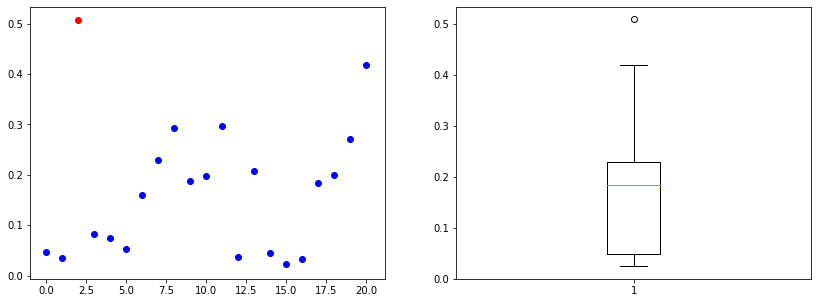

In [11]:
plt.figure(figsize=(14,5))
i = 0
plt.subplot(1,2,1)
for key in d_cv:
    if d_cv[key] <= upper_hkg:
        plt.scatter(i, d_cv[key], color="blue");
    else:
        plt.scatter(i, d_cv[key], color="red");
    i += 1
plt.subplot(1,2,2)
a = plt.boxplot(d_cv.values());

In [12]:
print("max cv: ", upper_hkg)
print("------------ outliers -------------")
for key, val in d_cv.items():
    if val >= upper_hkg:
        print(key, val)

max cv:  0.5005366248219769
------------ outliers -------------
idnT 0.5082800362135752


In [13]:
X_train = X_train.drop("idnT")
X_train.shape

(20, 9)

### data scaling

In [14]:
max_val = 1
min_val = -1
min_train = np.min(X_train)
max_train = np.max(X_train)
X_train = ((X_train - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


### One-classification

In [15]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(100, input_shape=(self.noise_input,)))
        model.add(Dense(100))
        model.add(Dense(100))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [139]:
noise_input = 18
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  18


In [140]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0],noise_input))
print("Dimension de los datos de entrada:", noise.shape)
data_fake = G.predict(noise)
print("Dimension de los ejemplos generados:", data_fake.shape)

Dimension de los datos de entrada: (20, 18)
Dimension de los ejemplos generados: (20, 9)


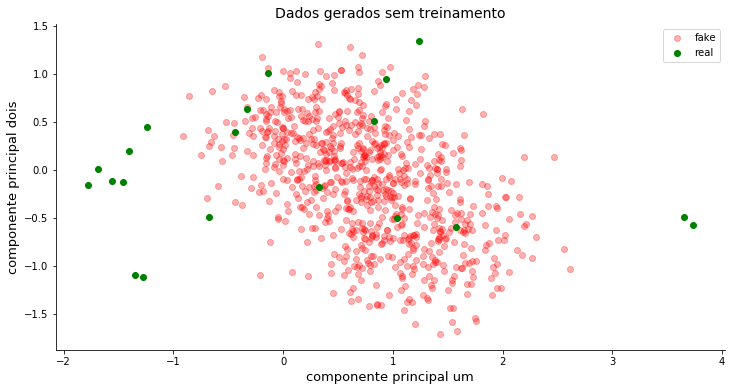

In [141]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)
X_train_pca
noise = np.random.normal(loc=0, scale=1, size=(800,noise_input))
fig1 = plt.figure(figsize=(12,6))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_fake_pca = pca_real.transform(x_noise)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="fake", alpha=.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1)
plt.legend();

In [142]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(32))
        model.add(Dropout(.1))
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [143]:
optimizerD = Adam(lr=0.0001, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

In [144]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [145]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [146]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    fscore = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_real = X_train.loc[np.random.choice(X_train.index.values, size=12, replace=False)]
        X_fake = G.predict(np.random.normal(0, 1, (12, noise_input)))
        X_test = np.concatenate((X_real, X_fake))
        y_test = np.concatenate((np.ones((12,1)), np.zeros((12,1))))
        y_predict = D.predict_classes(X_test)
        fscore.append(f1_score(y_test, y_predict))
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
    return g_loss, d_loss, fscore

In [147]:
noise_input = 7
#Gerador
#optimizerG = Adam(lr=0.0001, beta_1=0.4)
optimizerG = SGD(lr=0.0001, momentum=0.9, decay=0.0001/2000)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
#optimizerD = Adam(lr=0.002, beta_1=0.9)
optimizerD = SGD(lr=0.002, momentum=0.9, decay=0.002/2000)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  7
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_59 (Sequential)   (None, 9)                 21909     
_________________________________________________________________
sequential_60 (Sequential)   (None, 1)                 1409      
Total params: 23,318
Trainable params: 21,909
Non-trainable params: 1,409
_________________________________________________________________


In [148]:
ep = 2000
g_loss, d_loss, fscore = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan,
                       noise_input=noise_input)

epoch:[1/2000] [Discriminator::d_loss: 0.828798],[Generator::loss: 0.735936], 5.392791[sec]
epoch:[2/2000] [Discriminator::d_loss: 0.814667],[Generator::loss: 0.726908], 0.014372[sec]
epoch:[3/2000] [Discriminator::d_loss: 0.802056],[Generator::loss: 0.655182], 0.014226[sec]
epoch:[4/2000] [Discriminator::d_loss: 0.768473],[Generator::loss: 0.680837], 0.014100[sec]
epoch:[5/2000] [Discriminator::d_loss: 0.767402],[Generator::loss: 0.681568], 0.014371[sec]
epoch:[6/2000] [Discriminator::d_loss: 0.799049],[Generator::loss: 0.689000], 0.014170[sec]
epoch:[7/2000] [Discriminator::d_loss: 0.767237],[Generator::loss: 0.714113], 0.014094[sec]
epoch:[8/2000] [Discriminator::d_loss: 0.766216],[Generator::loss: 0.646404], 0.014073[sec]
epoch:[9/2000] [Discriminator::d_loss: 0.783828],[Generator::loss: 0.692349], 0.014174[sec]
epoch:[10/2000] [Discriminator::d_loss: 0.760904],[Generator::loss: 0.687790], 0.014124[sec]
epoch:[11/2000] [Discriminator::d_loss: 0.736000],[Generator::loss: 0.653068], 

epoch:[99/2000] [Discriminator::d_loss: 0.598839],[Generator::loss: 0.701501], 0.016639[sec]
epoch:[100/2000] [Discriminator::d_loss: 0.547544],[Generator::loss: 0.717666], 0.019458[sec]
epoch:[101/2000] [Discriminator::d_loss: 0.550120],[Generator::loss: 0.717001], 0.014594[sec]
epoch:[102/2000] [Discriminator::d_loss: 0.562141],[Generator::loss: 0.681066], 0.014358[sec]
epoch:[103/2000] [Discriminator::d_loss: 0.567303],[Generator::loss: 0.691248], 0.014059[sec]
epoch:[104/2000] [Discriminator::d_loss: 0.563142],[Generator::loss: 0.699870], 0.014018[sec]
epoch:[105/2000] [Discriminator::d_loss: 0.604953],[Generator::loss: 0.731202], 0.014076[sec]
epoch:[106/2000] [Discriminator::d_loss: 0.582926],[Generator::loss: 0.748757], 0.014121[sec]
epoch:[107/2000] [Discriminator::d_loss: 0.582194],[Generator::loss: 0.725024], 0.013924[sec]
epoch:[108/2000] [Discriminator::d_loss: 0.563871],[Generator::loss: 0.744203], 0.014007[sec]
epoch:[109/2000] [Discriminator::d_loss: 0.565442],[Generator

epoch:[194/2000] [Discriminator::d_loss: 0.518478],[Generator::loss: 0.815033], 0.022712[sec]
epoch:[195/2000] [Discriminator::d_loss: 0.529534],[Generator::loss: 0.871131], 0.024238[sec]
epoch:[196/2000] [Discriminator::d_loss: 0.495290],[Generator::loss: 0.829322], 0.017424[sec]
epoch:[197/2000] [Discriminator::d_loss: 0.509374],[Generator::loss: 0.881501], 0.020180[sec]
epoch:[198/2000] [Discriminator::d_loss: 0.538935],[Generator::loss: 0.865898], 0.015599[sec]
epoch:[199/2000] [Discriminator::d_loss: 0.496578],[Generator::loss: 0.907134], 0.014826[sec]
epoch:[200/2000] [Discriminator::d_loss: 0.499814],[Generator::loss: 0.829371], 0.014129[sec]
epoch:[201/2000] [Discriminator::d_loss: 0.496379],[Generator::loss: 0.834667], 0.014257[sec]
epoch:[202/2000] [Discriminator::d_loss: 0.508829],[Generator::loss: 0.904324], 0.014283[sec]
epoch:[203/2000] [Discriminator::d_loss: 0.509393],[Generator::loss: 0.882076], 0.014177[sec]
epoch:[204/2000] [Discriminator::d_loss: 0.501162],[Generato

epoch:[285/2000] [Discriminator::d_loss: 0.519848],[Generator::loss: 0.852887], 0.014836[sec]
epoch:[286/2000] [Discriminator::d_loss: 0.491749],[Generator::loss: 0.891483], 0.019805[sec]
epoch:[287/2000] [Discriminator::d_loss: 0.473940],[Generator::loss: 0.833499], 0.014817[sec]
epoch:[288/2000] [Discriminator::d_loss: 0.510439],[Generator::loss: 0.927204], 0.014196[sec]
epoch:[289/2000] [Discriminator::d_loss: 0.474421],[Generator::loss: 0.944483], 0.014200[sec]
epoch:[290/2000] [Discriminator::d_loss: 0.484849],[Generator::loss: 0.932591], 0.014060[sec]
epoch:[291/2000] [Discriminator::d_loss: 0.493378],[Generator::loss: 0.965294], 0.014139[sec]
epoch:[292/2000] [Discriminator::d_loss: 0.490611],[Generator::loss: 0.907440], 0.014280[sec]
epoch:[293/2000] [Discriminator::d_loss: 0.486032],[Generator::loss: 0.964744], 0.014650[sec]
epoch:[294/2000] [Discriminator::d_loss: 0.496315],[Generator::loss: 0.869959], 0.014296[sec]
epoch:[295/2000] [Discriminator::d_loss: 0.501475],[Generato

epoch:[376/2000] [Discriminator::d_loss: 0.525680],[Generator::loss: 0.972565], 0.018155[sec]
epoch:[377/2000] [Discriminator::d_loss: 0.518950],[Generator::loss: 0.933453], 0.017779[sec]
epoch:[378/2000] [Discriminator::d_loss: 0.530369],[Generator::loss: 0.905895], 0.015129[sec]
epoch:[379/2000] [Discriminator::d_loss: 0.508405],[Generator::loss: 1.011277], 0.014751[sec]
epoch:[380/2000] [Discriminator::d_loss: 0.548816],[Generator::loss: 0.895677], 0.014417[sec]
epoch:[381/2000] [Discriminator::d_loss: 0.536726],[Generator::loss: 1.046279], 0.019623[sec]
epoch:[382/2000] [Discriminator::d_loss: 0.513702],[Generator::loss: 0.998920], 0.028062[sec]
epoch:[383/2000] [Discriminator::d_loss: 0.562621],[Generator::loss: 1.054117], 0.021937[sec]
epoch:[384/2000] [Discriminator::d_loss: 0.499876],[Generator::loss: 0.955972], 0.015520[sec]
epoch:[385/2000] [Discriminator::d_loss: 0.508384],[Generator::loss: 0.836640], 0.015461[sec]
epoch:[386/2000] [Discriminator::d_loss: 0.534520],[Generato

epoch:[468/2000] [Discriminator::d_loss: 0.567610],[Generator::loss: 0.887141], 0.017353[sec]
epoch:[469/2000] [Discriminator::d_loss: 0.569028],[Generator::loss: 1.065826], 0.020056[sec]
epoch:[470/2000] [Discriminator::d_loss: 0.585879],[Generator::loss: 0.952257], 0.017770[sec]
epoch:[471/2000] [Discriminator::d_loss: 0.558648],[Generator::loss: 0.910598], 0.015450[sec]
epoch:[472/2000] [Discriminator::d_loss: 0.611298],[Generator::loss: 1.078033], 0.015179[sec]
epoch:[473/2000] [Discriminator::d_loss: 0.629924],[Generator::loss: 0.986163], 0.014794[sec]
epoch:[474/2000] [Discriminator::d_loss: 0.590123],[Generator::loss: 1.058095], 0.014488[sec]
epoch:[475/2000] [Discriminator::d_loss: 0.553164],[Generator::loss: 0.840949], 0.014025[sec]
epoch:[476/2000] [Discriminator::d_loss: 0.633330],[Generator::loss: 0.972340], 0.014335[sec]
epoch:[477/2000] [Discriminator::d_loss: 0.511856],[Generator::loss: 0.837622], 0.014324[sec]
epoch:[478/2000] [Discriminator::d_loss: 0.586614],[Generato

epoch:[559/2000] [Discriminator::d_loss: 0.579536],[Generator::loss: 0.894484], 0.017790[sec]
epoch:[560/2000] [Discriminator::d_loss: 0.601388],[Generator::loss: 0.860607], 0.021419[sec]
epoch:[561/2000] [Discriminator::d_loss: 0.658801],[Generator::loss: 0.889115], 0.016240[sec]
epoch:[562/2000] [Discriminator::d_loss: 0.583027],[Generator::loss: 0.856080], 0.016593[sec]
epoch:[563/2000] [Discriminator::d_loss: 0.647381],[Generator::loss: 1.029686], 0.018044[sec]
epoch:[564/2000] [Discriminator::d_loss: 0.642365],[Generator::loss: 0.959246], 0.016641[sec]
epoch:[565/2000] [Discriminator::d_loss: 0.587594],[Generator::loss: 1.019950], 0.016726[sec]
epoch:[566/2000] [Discriminator::d_loss: 0.684073],[Generator::loss: 0.918272], 0.016375[sec]
epoch:[567/2000] [Discriminator::d_loss: 0.642501],[Generator::loss: 0.919187], 0.016213[sec]
epoch:[568/2000] [Discriminator::d_loss: 0.662739],[Generator::loss: 1.073991], 0.014851[sec]
epoch:[569/2000] [Discriminator::d_loss: 0.666667],[Generato

epoch:[649/2000] [Discriminator::d_loss: 0.689787],[Generator::loss: 0.886372], 0.016698[sec]
epoch:[650/2000] [Discriminator::d_loss: 0.680682],[Generator::loss: 1.107183], 0.014844[sec]
epoch:[651/2000] [Discriminator::d_loss: 0.585546],[Generator::loss: 0.829499], 0.014248[sec]
epoch:[652/2000] [Discriminator::d_loss: 0.654353],[Generator::loss: 0.892390], 0.014692[sec]
epoch:[653/2000] [Discriminator::d_loss: 0.573603],[Generator::loss: 0.783477], 0.014590[sec]
epoch:[654/2000] [Discriminator::d_loss: 0.703539],[Generator::loss: 0.818378], 0.014446[sec]
epoch:[655/2000] [Discriminator::d_loss: 0.705239],[Generator::loss: 0.888502], 0.016181[sec]
epoch:[656/2000] [Discriminator::d_loss: 0.695293],[Generator::loss: 0.993694], 0.015127[sec]
epoch:[657/2000] [Discriminator::d_loss: 0.674022],[Generator::loss: 0.987301], 0.015129[sec]
epoch:[658/2000] [Discriminator::d_loss: 0.705867],[Generator::loss: 0.941101], 0.014563[sec]
epoch:[659/2000] [Discriminator::d_loss: 0.713050],[Generato

epoch:[745/2000] [Discriminator::d_loss: 0.697803],[Generator::loss: 0.910745], 0.019039[sec]
epoch:[746/2000] [Discriminator::d_loss: 0.694180],[Generator::loss: 0.904309], 0.018067[sec]
epoch:[747/2000] [Discriminator::d_loss: 0.689600],[Generator::loss: 0.854023], 0.015186[sec]
epoch:[748/2000] [Discriminator::d_loss: 0.679301],[Generator::loss: 0.882209], 0.017273[sec]
epoch:[749/2000] [Discriminator::d_loss: 0.703520],[Generator::loss: 0.745304], 0.015278[sec]
epoch:[750/2000] [Discriminator::d_loss: 0.671647],[Generator::loss: 0.740571], 0.016657[sec]
epoch:[751/2000] [Discriminator::d_loss: 0.712524],[Generator::loss: 0.777155], 0.016868[sec]
epoch:[752/2000] [Discriminator::d_loss: 0.783104],[Generator::loss: 0.834041], 0.015522[sec]
epoch:[753/2000] [Discriminator::d_loss: 0.698112],[Generator::loss: 0.962539], 0.015958[sec]
epoch:[754/2000] [Discriminator::d_loss: 0.703510],[Generator::loss: 0.745442], 0.015657[sec]
epoch:[755/2000] [Discriminator::d_loss: 0.669285],[Generato

epoch:[839/2000] [Discriminator::d_loss: 0.686302],[Generator::loss: 0.828584], 0.017489[sec]
epoch:[840/2000] [Discriminator::d_loss: 0.692765],[Generator::loss: 0.812443], 0.018980[sec]
epoch:[841/2000] [Discriminator::d_loss: 0.646470],[Generator::loss: 0.884832], 0.014944[sec]
epoch:[842/2000] [Discriminator::d_loss: 0.704069],[Generator::loss: 0.862557], 0.016793[sec]
epoch:[843/2000] [Discriminator::d_loss: 0.653907],[Generator::loss: 0.875828], 0.016983[sec]
epoch:[844/2000] [Discriminator::d_loss: 0.679810],[Generator::loss: 0.770131], 0.015549[sec]
epoch:[845/2000] [Discriminator::d_loss: 0.672298],[Generator::loss: 0.814570], 0.016522[sec]
epoch:[846/2000] [Discriminator::d_loss: 0.689590],[Generator::loss: 0.915750], 0.017380[sec]
epoch:[847/2000] [Discriminator::d_loss: 0.668071],[Generator::loss: 0.821491], 0.015833[sec]
epoch:[848/2000] [Discriminator::d_loss: 0.713801],[Generator::loss: 0.871673], 0.017223[sec]
epoch:[849/2000] [Discriminator::d_loss: 0.712078],[Generato

epoch:[932/2000] [Discriminator::d_loss: 0.704247],[Generator::loss: 0.764236], 0.015254[sec]
epoch:[933/2000] [Discriminator::d_loss: 0.706017],[Generator::loss: 0.813944], 0.018467[sec]
epoch:[934/2000] [Discriminator::d_loss: 0.677289],[Generator::loss: 0.808155], 0.014750[sec]
epoch:[935/2000] [Discriminator::d_loss: 0.656902],[Generator::loss: 0.836777], 0.014425[sec]
epoch:[936/2000] [Discriminator::d_loss: 0.646574],[Generator::loss: 0.812037], 0.014477[sec]
epoch:[937/2000] [Discriminator::d_loss: 0.699464],[Generator::loss: 0.843459], 0.014297[sec]
epoch:[938/2000] [Discriminator::d_loss: 0.706680],[Generator::loss: 0.908760], 0.014250[sec]
epoch:[939/2000] [Discriminator::d_loss: 0.669641],[Generator::loss: 0.777315], 0.014131[sec]
epoch:[940/2000] [Discriminator::d_loss: 0.648338],[Generator::loss: 0.773960], 0.014114[sec]
epoch:[941/2000] [Discriminator::d_loss: 0.687123],[Generator::loss: 0.744496], 0.014235[sec]
epoch:[942/2000] [Discriminator::d_loss: 0.689141],[Generato

epoch:[1030/2000] [Discriminator::d_loss: 0.684868],[Generator::loss: 0.824109], 0.014781[sec]
epoch:[1031/2000] [Discriminator::d_loss: 0.663942],[Generator::loss: 0.798157], 0.020080[sec]
epoch:[1032/2000] [Discriminator::d_loss: 0.663805],[Generator::loss: 0.824472], 0.014941[sec]
epoch:[1033/2000] [Discriminator::d_loss: 0.680660],[Generator::loss: 0.790976], 0.014819[sec]
epoch:[1034/2000] [Discriminator::d_loss: 0.658699],[Generator::loss: 0.824480], 0.015632[sec]
epoch:[1035/2000] [Discriminator::d_loss: 0.659968],[Generator::loss: 0.767581], 0.016887[sec]
epoch:[1036/2000] [Discriminator::d_loss: 0.666109],[Generator::loss: 0.777814], 0.014431[sec]
epoch:[1037/2000] [Discriminator::d_loss: 0.665758],[Generator::loss: 0.790516], 0.015789[sec]
epoch:[1038/2000] [Discriminator::d_loss: 0.678501],[Generator::loss: 0.775294], 0.015930[sec]
epoch:[1039/2000] [Discriminator::d_loss: 0.645405],[Generator::loss: 0.746254], 0.016799[sec]
epoch:[1040/2000] [Discriminator::d_loss: 0.678580

epoch:[1127/2000] [Discriminator::d_loss: 0.647294],[Generator::loss: 0.791002], 0.014325[sec]
epoch:[1128/2000] [Discriminator::d_loss: 0.672490],[Generator::loss: 0.786727], 0.016921[sec]
epoch:[1129/2000] [Discriminator::d_loss: 0.667419],[Generator::loss: 0.780083], 0.014389[sec]
epoch:[1130/2000] [Discriminator::d_loss: 0.657443],[Generator::loss: 0.804761], 0.014470[sec]
epoch:[1131/2000] [Discriminator::d_loss: 0.663444],[Generator::loss: 0.769507], 0.014572[sec]
epoch:[1132/2000] [Discriminator::d_loss: 0.668857],[Generator::loss: 0.805604], 0.013911[sec]
epoch:[1133/2000] [Discriminator::d_loss: 0.648578],[Generator::loss: 0.744356], 0.014074[sec]
epoch:[1134/2000] [Discriminator::d_loss: 0.658155],[Generator::loss: 0.750964], 0.015193[sec]
epoch:[1135/2000] [Discriminator::d_loss: 0.675265],[Generator::loss: 0.760163], 0.014423[sec]
epoch:[1136/2000] [Discriminator::d_loss: 0.669430],[Generator::loss: 0.801787], 0.014062[sec]
epoch:[1137/2000] [Discriminator::d_loss: 0.659402

epoch:[1225/2000] [Discriminator::d_loss: 0.669875],[Generator::loss: 0.792463], 0.014562[sec]
epoch:[1226/2000] [Discriminator::d_loss: 0.656502],[Generator::loss: 0.772994], 0.017565[sec]
epoch:[1227/2000] [Discriminator::d_loss: 0.689615],[Generator::loss: 0.745592], 0.015278[sec]
epoch:[1228/2000] [Discriminator::d_loss: 0.667254],[Generator::loss: 0.716474], 0.014535[sec]
epoch:[1229/2000] [Discriminator::d_loss: 0.644357],[Generator::loss: 0.759847], 0.014068[sec]
epoch:[1230/2000] [Discriminator::d_loss: 0.686552],[Generator::loss: 0.754714], 0.013959[sec]
epoch:[1231/2000] [Discriminator::d_loss: 0.676473],[Generator::loss: 0.770729], 0.014190[sec]
epoch:[1232/2000] [Discriminator::d_loss: 0.670928],[Generator::loss: 0.782002], 0.013973[sec]
epoch:[1233/2000] [Discriminator::d_loss: 0.736558],[Generator::loss: 0.744076], 0.014063[sec]
epoch:[1234/2000] [Discriminator::d_loss: 0.652376],[Generator::loss: 0.744463], 0.014024[sec]
epoch:[1235/2000] [Discriminator::d_loss: 0.695634

epoch:[1323/2000] [Discriminator::d_loss: 0.631220],[Generator::loss: 0.740143], 0.014678[sec]
epoch:[1324/2000] [Discriminator::d_loss: 0.680864],[Generator::loss: 0.724261], 0.023455[sec]
epoch:[1325/2000] [Discriminator::d_loss: 0.641631],[Generator::loss: 0.740975], 0.015002[sec]
epoch:[1326/2000] [Discriminator::d_loss: 0.659571],[Generator::loss: 0.794599], 0.014391[sec]
epoch:[1327/2000] [Discriminator::d_loss: 0.661888],[Generator::loss: 0.780909], 0.014191[sec]
epoch:[1328/2000] [Discriminator::d_loss: 0.680673],[Generator::loss: 0.735604], 0.014123[sec]
epoch:[1329/2000] [Discriminator::d_loss: 0.655709],[Generator::loss: 0.759970], 0.014068[sec]
epoch:[1330/2000] [Discriminator::d_loss: 0.674483],[Generator::loss: 0.735306], 0.014292[sec]
epoch:[1331/2000] [Discriminator::d_loss: 0.649302],[Generator::loss: 0.773508], 0.013954[sec]
epoch:[1332/2000] [Discriminator::d_loss: 0.663758],[Generator::loss: 0.737355], 0.014730[sec]
epoch:[1333/2000] [Discriminator::d_loss: 0.655001

epoch:[1421/2000] [Discriminator::d_loss: 0.646508],[Generator::loss: 0.782626], 0.015723[sec]
epoch:[1422/2000] [Discriminator::d_loss: 0.636954],[Generator::loss: 0.826891], 0.020832[sec]
epoch:[1423/2000] [Discriminator::d_loss: 0.637983],[Generator::loss: 0.799132], 0.014772[sec]
epoch:[1424/2000] [Discriminator::d_loss: 0.633841],[Generator::loss: 0.791073], 0.014462[sec]
epoch:[1425/2000] [Discriminator::d_loss: 0.635013],[Generator::loss: 0.809875], 0.014267[sec]
epoch:[1426/2000] [Discriminator::d_loss: 0.654815],[Generator::loss: 0.798913], 0.014413[sec]
epoch:[1427/2000] [Discriminator::d_loss: 0.647563],[Generator::loss: 0.782457], 0.014370[sec]
epoch:[1428/2000] [Discriminator::d_loss: 0.638146],[Generator::loss: 0.771845], 0.014417[sec]
epoch:[1429/2000] [Discriminator::d_loss: 0.629394],[Generator::loss: 0.781415], 0.014232[sec]
epoch:[1430/2000] [Discriminator::d_loss: 0.635716],[Generator::loss: 0.809814], 0.014759[sec]
epoch:[1431/2000] [Discriminator::d_loss: 0.652365

epoch:[1516/2000] [Discriminator::d_loss: 0.622914],[Generator::loss: 0.749532], 0.016383[sec]
epoch:[1517/2000] [Discriminator::d_loss: 0.646898],[Generator::loss: 0.692981], 0.026266[sec]
epoch:[1518/2000] [Discriminator::d_loss: 0.632880],[Generator::loss: 0.821319], 0.017823[sec]
epoch:[1519/2000] [Discriminator::d_loss: 0.625710],[Generator::loss: 0.714426], 0.018197[sec]
epoch:[1520/2000] [Discriminator::d_loss: 0.624448],[Generator::loss: 0.803587], 0.017606[sec]
epoch:[1521/2000] [Discriminator::d_loss: 0.630972],[Generator::loss: 0.762133], 0.014860[sec]
epoch:[1522/2000] [Discriminator::d_loss: 0.636017],[Generator::loss: 0.749311], 0.014995[sec]
epoch:[1523/2000] [Discriminator::d_loss: 0.651399],[Generator::loss: 0.765665], 0.015457[sec]
epoch:[1524/2000] [Discriminator::d_loss: 0.637585],[Generator::loss: 0.757401], 0.014360[sec]
epoch:[1525/2000] [Discriminator::d_loss: 0.632355],[Generator::loss: 0.737320], 0.014385[sec]
epoch:[1526/2000] [Discriminator::d_loss: 0.615209

epoch:[1608/2000] [Discriminator::d_loss: 0.645227],[Generator::loss: 0.772522], 0.014678[sec]
epoch:[1609/2000] [Discriminator::d_loss: 0.656259],[Generator::loss: 0.767089], 0.016658[sec]
epoch:[1610/2000] [Discriminator::d_loss: 0.652878],[Generator::loss: 0.740919], 0.015172[sec]
epoch:[1611/2000] [Discriminator::d_loss: 0.626976],[Generator::loss: 0.756325], 0.014517[sec]
epoch:[1612/2000] [Discriminator::d_loss: 0.644791],[Generator::loss: 0.786965], 0.013961[sec]
epoch:[1613/2000] [Discriminator::d_loss: 0.613705],[Generator::loss: 0.832193], 0.014215[sec]
epoch:[1614/2000] [Discriminator::d_loss: 0.624905],[Generator::loss: 0.768048], 0.014181[sec]
epoch:[1615/2000] [Discriminator::d_loss: 0.606518],[Generator::loss: 0.823881], 0.014069[sec]
epoch:[1616/2000] [Discriminator::d_loss: 0.614316],[Generator::loss: 0.736726], 0.014360[sec]
epoch:[1617/2000] [Discriminator::d_loss: 0.668042],[Generator::loss: 0.762839], 0.014396[sec]
epoch:[1618/2000] [Discriminator::d_loss: 0.643988

epoch:[1704/2000] [Discriminator::d_loss: 0.650443],[Generator::loss: 0.697425], 0.018794[sec]
epoch:[1705/2000] [Discriminator::d_loss: 0.685066],[Generator::loss: 0.735954], 0.023435[sec]
epoch:[1706/2000] [Discriminator::d_loss: 0.655447],[Generator::loss: 0.714121], 0.016079[sec]
epoch:[1707/2000] [Discriminator::d_loss: 0.663155],[Generator::loss: 0.768173], 0.015898[sec]
epoch:[1708/2000] [Discriminator::d_loss: 0.643789],[Generator::loss: 0.717297], 0.016312[sec]
epoch:[1709/2000] [Discriminator::d_loss: 0.617585],[Generator::loss: 0.806488], 0.018379[sec]
epoch:[1710/2000] [Discriminator::d_loss: 0.591706],[Generator::loss: 0.815612], 0.019196[sec]
epoch:[1711/2000] [Discriminator::d_loss: 0.641054],[Generator::loss: 0.780202], 0.015960[sec]
epoch:[1712/2000] [Discriminator::d_loss: 0.644664],[Generator::loss: 0.741952], 0.015592[sec]
epoch:[1713/2000] [Discriminator::d_loss: 0.690467],[Generator::loss: 0.727262], 0.015194[sec]
epoch:[1714/2000] [Discriminator::d_loss: 0.650897

epoch:[1799/2000] [Discriminator::d_loss: 0.648195],[Generator::loss: 0.812796], 0.020552[sec]
epoch:[1800/2000] [Discriminator::d_loss: 0.636193],[Generator::loss: 0.799150], 0.020003[sec]
epoch:[1801/2000] [Discriminator::d_loss: 0.602544],[Generator::loss: 0.734177], 0.019832[sec]
epoch:[1802/2000] [Discriminator::d_loss: 0.648339],[Generator::loss: 0.797262], 0.017206[sec]
epoch:[1803/2000] [Discriminator::d_loss: 0.633306],[Generator::loss: 0.745665], 0.016612[sec]
epoch:[1804/2000] [Discriminator::d_loss: 0.655620],[Generator::loss: 0.767331], 0.016712[sec]
epoch:[1805/2000] [Discriminator::d_loss: 0.622648],[Generator::loss: 0.794525], 0.016648[sec]
epoch:[1806/2000] [Discriminator::d_loss: 0.658921],[Generator::loss: 0.809055], 0.016306[sec]
epoch:[1807/2000] [Discriminator::d_loss: 0.649683],[Generator::loss: 0.750725], 0.019485[sec]
epoch:[1808/2000] [Discriminator::d_loss: 0.658831],[Generator::loss: 0.767738], 0.016441[sec]
epoch:[1809/2000] [Discriminator::d_loss: 0.647807

epoch:[1889/2000] [Discriminator::d_loss: 0.615243],[Generator::loss: 0.724008], 0.014671[sec]
epoch:[1890/2000] [Discriminator::d_loss: 0.626611],[Generator::loss: 0.716611], 0.019992[sec]
epoch:[1891/2000] [Discriminator::d_loss: 0.612647],[Generator::loss: 0.655559], 0.014701[sec]
epoch:[1892/2000] [Discriminator::d_loss: 0.639009],[Generator::loss: 0.826045], 0.014362[sec]
epoch:[1893/2000] [Discriminator::d_loss: 0.644315],[Generator::loss: 0.709542], 0.016061[sec]
epoch:[1894/2000] [Discriminator::d_loss: 0.644788],[Generator::loss: 0.880092], 0.014525[sec]
epoch:[1895/2000] [Discriminator::d_loss: 0.660112],[Generator::loss: 0.734573], 0.014445[sec]
epoch:[1896/2000] [Discriminator::d_loss: 0.637417],[Generator::loss: 0.763182], 0.014715[sec]
epoch:[1897/2000] [Discriminator::d_loss: 0.636020],[Generator::loss: 0.826887], 0.014356[sec]
epoch:[1898/2000] [Discriminator::d_loss: 0.672311],[Generator::loss: 0.786187], 0.015280[sec]
epoch:[1899/2000] [Discriminator::d_loss: 0.608286

epoch:[1987/2000] [Discriminator::d_loss: 0.637121],[Generator::loss: 0.858408], 0.018020[sec]
epoch:[1988/2000] [Discriminator::d_loss: 0.660418],[Generator::loss: 0.862730], 0.019161[sec]
epoch:[1989/2000] [Discriminator::d_loss: 0.611817],[Generator::loss: 0.794303], 0.017351[sec]
epoch:[1990/2000] [Discriminator::d_loss: 0.642905],[Generator::loss: 0.760905], 0.015935[sec]
epoch:[1991/2000] [Discriminator::d_loss: 0.644394],[Generator::loss: 0.797251], 0.015992[sec]
epoch:[1992/2000] [Discriminator::d_loss: 0.625610],[Generator::loss: 0.820068], 0.016881[sec]
epoch:[1993/2000] [Discriminator::d_loss: 0.631927],[Generator::loss: 0.749027], 0.016730[sec]
epoch:[1994/2000] [Discriminator::d_loss: 0.645608],[Generator::loss: 0.846320], 0.018166[sec]
epoch:[1995/2000] [Discriminator::d_loss: 0.648754],[Generator::loss: 0.790861], 0.026276[sec]
epoch:[1996/2000] [Discriminator::d_loss: 0.639327],[Generator::loss: 0.707867], 0.022870[sec]
epoch:[1997/2000] [Discriminator::d_loss: 0.659911

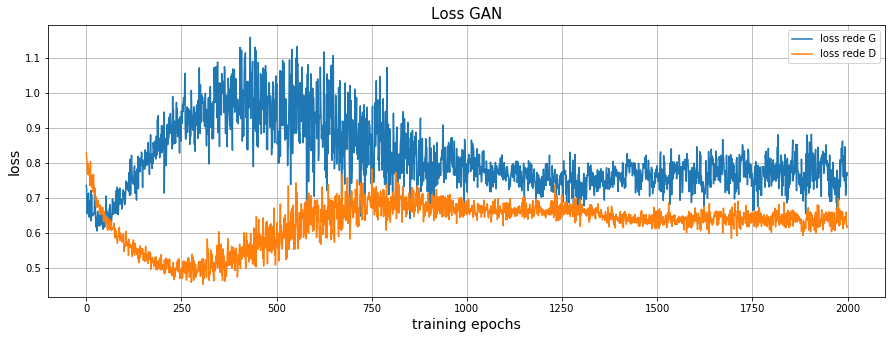

In [149]:
plt.figure(figsize=(15,5))
plt.title("Loss GAN", fontsize=15)
plt.plot(range(ep), g_loss, label="loss rede G")
plt.plot(range(ep), d_loss, label="loss rede D")
plt.xlabel("training epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

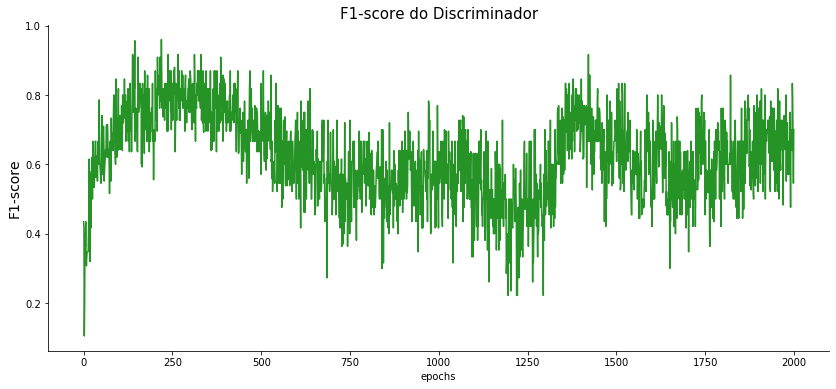

In [150]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("F1-score do Discriminador", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("F1-score", fontsize=14)
plt.plot(range(len(fscore)), fscore, color="green", alpha=.85);

(20, 2) (800, 2)


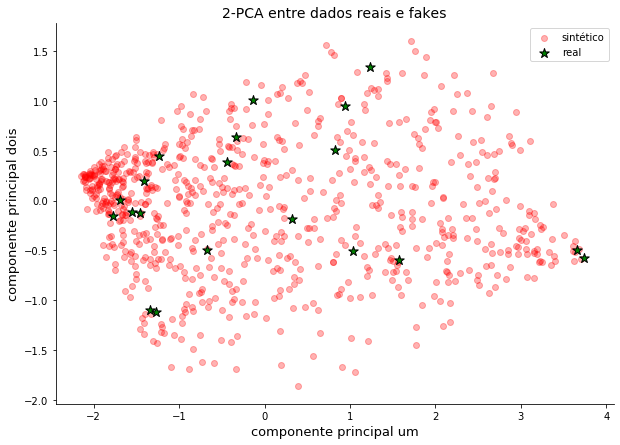

In [151]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(800,noise_input)))
X_fake_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_fake_pca.shape)
plt.title("2-PCA entre dados reais e fakes", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();